# Ансамблирование

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split

%matplotlib inline

## Загрузка данных и EDA

In [ ]:
# Загрузим набор данных
df_orig = pd.read_csv('ames_price.csv')

# Уберем столбец с ИД как неинформативный и создающий ненужный шум
df_full = df_orig.drop('Id', axis=1)

In [ ]:
df_full.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
# Посмотрим, какие типы данных содержатся в наборе данных
print(df_full.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 80 entries, MSSubClass to SalePrice
dtypes: float64(3), int64(34), object(43)
memory usage: 912.6+ KB
None


Итак, у нас в наборе данных 80 столбцов - 1 целевая переменная и 79 признаков, 43 из которых категориальные.

In [ ]:
# Посмотрим, сколько у нас пропущенных значений
print(f'Количество пропущенных значений в наборе данных до обработки: {df_full.isna().sum().sum()}')

# Количество пропущенных значений для такого набора данных весьма велико.

Количество пропущенных значений в наборе данных до обработки: 6965


In [ ]:
# Создадим копию набора данный, в которой удалим\заменим отсутсвующие значения после EDA
df_out = df_full.copy()

# Для сравнения качества моделей в дальнейшем, оставим полный датасет с заменой отсутствующих значений на произвольное значение
cat_col = df_full.select_dtypes(include=['object']).columns.tolist()
df_full[cat_col] = df_full[cat_col].fillna('nan')

num_col = df_full.select_dtypes(include=['float64', 'int64']).columns.tolist()
df_full[num_col] = df_full[num_col].fillna(-999)

print(f'Количество отсутствующих значений в полном наборе данных: {df_full.isna().sum().sum()}')
print(f'Количество отсутствующих значений в копии набора данных: {df_out.isna().sum().sum()}')

Количество отсутствующих значений в полном наборе данных: 0
Количество отсутствующих значений в копии набора данных: 6965


In [ ]:
# Напишем небольшую функцию для расчёта процента пропущенных значений в столбце
# Параметры этой функции - 
def missing_values_to_drop(df, nan_ratio):
  '''
    Функция для расчёта процента пропущенных значений в столбце pandas датафрейма.
    Функция принимает датафрейм и пороговый параметр процента пропущенных значений, выше которого
    она собирает названия столбцов и процент пропущенных значений в словарь для ознакомления, а также
    названия столбцов в список для последующей фильтрации датафрейма.
    Функция возвращает словарь для ознакомления и список для фильтрации.
  '''
  # Общее число строк в наборе данных
  total_rows = df.shape[0]

  # Хранилище для названия столбцов и процентов пропущенных значений выше порогового параметра
  miss_column_dict = {}

  for column in df.columns:
    nan = df[column].isna().sum()
    ratio = round(nan*100/total_rows, 2)
  
  # Если процент больше порогового параметра
    if ratio > nan_ratio:
    # Добавим в хранилище
      miss_column_dict[column] = ratio

  list_to_drop = list(miss_column_dict.keys())
  return miss_column_dict, list_to_drop

In [ ]:
# Предположим, я хочу посмотреть на все столбцы, где больше 80% пропущенных значений
# Целесообразно будет такие столбцы исключить полностью, ведь даже при замене пропусков на категорию-индикатор пропуска, эта категория-индикатор
# может начать привносить ненужный шум
col_80, list_80 = missing_values_to_drop(df_out, 80)

for key, value in col_80.items():
  print(f'В столбце {key} процент пропущенных значений: {value}')

print(f'\nСписок столбцов под удаление: {list_80}')

В столбце Alley процент пропущенных значений: 93.77
В столбце PoolQC процент пропущенных значений: 99.52
В столбце Fence процент пропущенных значений: 80.75
В столбце MiscFeature процент пропущенных значений: 96.3

Список столбцов под удаление: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [ ]:
# Удалим эти столбцы
#df_out = df_out.drop(df_out[list_80], axis=1)

In [ ]:
# Посмотрим, сколько у нас пропущенных значений теперь
print(f'Количество пропущенных значений в наборе данных после обработки: {df_out.isna().sum().sum()}')

Количество пропущенных значений в наборе данных после обработки: 6965


In [ ]:
# Сам набор данных, в любом случае, не очень большой, поэтому удалять пропущенные значения контрпродуктивно
# Предлагаю заменить пропущенные значения в категориальных переменных на NaN, чтобы, когда мы будем отображать категории
# в численный вид, NaN тоже имела свою категорию
cat_col = df_out.select_dtypes(include=['object']).columns.tolist()
df_out[cat_col] = df_out[cat_col].fillna('nan')

print(f'Количество пропущенных значений в наборе данных после замены категорий: {df_out.isna().sum().sum()}')

Количество пропущенных значений в наборе данных после замены категорий: 348


'''
Перед тем, как заменять пропущенные значения в численных столбцах, предлагаю взглянуть на выбросы
Боксплот по численным столбцам
'''

num_col = df_out.select_dtypes(include=['float64', 'int64']).columns.tolist()

plt.rcParams["figure.figsize"] = [10, 6]

for n_col in df_out[num_col].columns:
  
  df_out[n_col].plot.box(vert=False)
  
  plt.title(n_col)
  
  plt.show()

По результатам исследования ящиков с усами:


In [ ]:
MSSubClass_o = df_out['MSSubClass'][df_out['MSSubClass'] > 150]
print(f'Количество строк выбросов по боксплоту в столбце MSSubClass: {MSSubClass_o.count()}')

LotFrontage_o = df_out['LotFrontage'][df_out['LotFrontage'] > 300]
print(f'Количество строк выбросов по боксплоту в столбце LotFrontage: {LotFrontage_o.count()}')

LotArea_o = df_out['LotArea'][df_out['LotArea'] > 100000]
print(f'Количество строк выбросов по боксплоту в столбце LotArea: {LotArea_o.count()}')

OverallQual_o = df_out['OverallQual'][df_out['OverallQual'] < 2]
print(f'Количество строк выбросов по боксплоту в столбце LotArea: {OverallQual_o.count()}')

OverallCond_o = df_out['OverallCond'][(df_out['OverallCond'] < 4) | (df_out['OverallCond'] > 7)]
print(f'Количество строк выбросов по боксплоту в столбце OverallCond: {OverallCond_o.count()}')

MasVnrArea_o = df_out['MasVnrArea'][df_out['MasVnrArea'] > 1100]
print(f'Количество строк выбросов по боксплоту в столбце MasVnrArea: {MasVnrArea_o.count()}')

BsmtFinSF1_o = df_out['BsmtFinSF1'][df_out['BsmtFinSF1'] > 3000]
print(f'Количество строк выбросов по боксплоту в столбце BsmtFinSF1: {BsmtFinSF1_o.count()}')

BsmtFinSF2_o = df_out['BsmtFinSF2'][df_out['BsmtFinSF2'] > 1400]
print(f'Количество строк выбросов по боксплоту в столбце BsmtFinSF2: {BsmtFinSF2_o.count()}')

BsmtUnfSF_o = df_out['BsmtUnfSF'][df_out['BsmtUnfSF'] > 2100]
print(f'Количество строк выбросов по боксплоту в столбце BsmtUnfSF: {BsmtUnfSF_o.count()}')

TotalBsmtSF_o = df_out['TotalBsmtSF'][df_out['TotalBsmtSF'] > 3000]
print(f'Количество строк выбросов по боксплоту в столбце TotalBsmtSF: {TotalBsmtSF_o.count()}')

_1stFlrSF_o = df_out['1stFlrSF'][df_out['1stFlrSF'] > 3000]
print(f'Количество строк выбросов по боксплоту в столбце 1stFlrSF: {_1stFlrSF_o.count()}')

_2ndFlrSF_o = df_out['2ndFlrSF'][df_out['2ndFlrSF'] > 2000]
print(f'Количество строк выбросов по боксплоту в столбце 2ndFlrSF: {_2ndFlrSF_o.count()}')

GrLivArea_o = df_out['GrLivArea'][df_out['GrLivArea'] > 4000]
print(f'Количество строк выбросов по боксплоту в столбце GrLivArea: {GrLivArea_o.count()}')

EnclosedPorch_o = df_out['EnclosedPorch'][df_out['EnclosedPorch'] > 500]
print(f'Количество строк выбросов по боксплоту в столбце EnclosedPorch: {EnclosedPorch_o.count()}')

_3SsnPorch_o = df_out['3SsnPorch'][df_out['3SsnPorch'] > 400]
print(f'Количество строк выбросов по боксплоту в столбце 3SsnPorch: {_3SsnPorch_o.count()}')

ScreenPorch_o = df_out['ScreenPorch'][df_out['ScreenPorch'] > 350]
print(f'Количество строк выбросов по боксплоту в столбце ScreenPorch: {ScreenPorch_o.count()}')

MiscVal_o = df_out['MiscVal'][df_out['MiscVal'] > 8000]
print(f'Количество строк выбросов по боксплоту в столбце MiscVal: {MiscVal_o.count()}')

Количество строк выбросов по боксплоту в столбце MSSubClass: 103
Количество строк выбросов по боксплоту в столбце LotFrontage: 2
Количество строк выбросов по боксплоту в столбце LotArea: 4
Количество строк выбросов по боксплоту в столбце LotArea: 2
Количество строк выбросов по боксплоту в столбце OverallCond: 125
Количество строк выбросов по боксплоту в столбце MasVnrArea: 5
Количество строк выбросов по боксплоту в столбце BsmtFinSF1: 1
Количество строк выбросов по боксплоту в столбце BsmtFinSF2: 1
Количество строк выбросов по боксплоту в столбце BsmtUnfSF: 3
Количество строк выбросов по боксплоту в столбце TotalBsmtSF: 5
Количество строк выбросов по боксплоту в столбце 1stFlrSF: 3
Количество строк выбросов по боксплоту в столбце 2ndFlrSF: 1
Количество строк выбросов по боксплоту в столбце GrLivArea: 4
Количество строк выбросов по боксплоту в столбце EnclosedPorch: 1
Количество строк выбросов по боксплоту в столбце 3SsnPorch: 2
Количество строк выбросов по боксплоту в столбце ScreenPor

In [ ]:
# Список для хранения индексов выбросов
out_col = []
#out_col.append(LotFrontage_o.index.tolist())
out_col.append(LotArea_o.index.tolist())
out_col.append(OverallQual_o.index.tolist())
out_col.append(MasVnrArea_o.index.tolist())
out_col.append(BsmtFinSF1_o.index.tolist())
out_col.append(BsmtFinSF2_o.index.tolist())
out_col.append(BsmtUnfSF_o.index.tolist())
out_col.append(TotalBsmtSF_o.index.tolist())
out_col.append(_1stFlrSF_o.index.tolist())
out_col.append(_2ndFlrSF_o.index.tolist())
out_col.append(GrLivArea_o.index.tolist())
out_col.append(EnclosedPorch_o.index.tolist())
out_col.append(_3SsnPorch_o.index.tolist())
out_col.append(ScreenPorch_o.index.tolist())
out_col.append(MiscVal_o.index.tolist())

# Делаем из списка списков простой список
out_col = list(itertools.chain.from_iterable(out_col))

# Удаляем дубликаты
out_col = list(dict.fromkeys(out_col))

# Сколько всего строк с выбросами удалю из набора данных
print(f'Всего выбросов под удаление: {len(out_col)}, процент строк под удаление: {round(len(out_col)*100/df_out.shape[0], 2)}')

Всего выбросов под удаление: 32, процент строк под удаление: 2.19


In [ ]:
# Удаляем выбросы по индексам
df_out = df_out.drop(index=out_col)

# Обновим индексы
df_out = df_out.reset_index(drop=True)
df_full = df_full.reset_index(drop=True)

# Заменим пропущенные значения в числовых столбцах на медианное
df_out = df_out.fillna(df_out.median())

print(f'Количество отсутствующих значений в датасете без выбросов: {df_out.isna().sum().sum()}')
print(f'Количество отсутствующих значений в полном датасете: {df_full.isna().sum().sum()}')

Количество отсутствующих значений в датасете без выбросов: 0
Количество отсутствующих значений в полном датасете: 0


## Подготовка данных к моделированию

In [ ]:
def cat_str_to_num(df):
  '''
    Функция для преобразования категориальных строковых столбцов в столбцы-индикаторы.
    Функция принимает датафрейм. 
    Функция возвращает датафрейм с преобразованными столбцами, где больше нет строковых значений.
  '''
  cat_col = df.select_dtypes(include=['object', 'category']).columns.tolist()
  for column in df[cat_col]:
    df_dum = pd.get_dummies(df[column])
    df = pd.concat([df, df_dum], axis='columns')
    df.drop([column], axis='columns', inplace=True)
  return df

In [ ]:
# Преобразуем оба датафрейма из прошлой части, чтобы подготовить их для отправки в модель
df_out = cat_str_to_num(df_out)
df_full = cat_str_to_num(df_full)

In [ ]:
def make_x_y_lists(df, target):
  '''
    Функция для создания списка столбцов для признаков и записи значения столбца целевой переменной.
    Принимает в качестве параметров датафрейм и наименование столбца целевой переменной.
    Выдает датафрейм с признаками и вектор целевой переменной
  '''
  x = df.loc[:, df.columns != target]
  y = df[target]
  return x, y

In [ ]:
def train_test(x, y, size=0.25, random_seed=42):
  '''
    Функция для разделения набора данных на обучающую и тестовую выборки.
    Принимает отфильтрованный на признаки и целевую переменную набор данных, размер тестовой выборки и фиксатор генератора случайных чисел.
    Возвращает набор данных, разделенный на тестовую и обучающую выборки
  '''
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=random_seed)
  return X_train, X_test, y_train, y_test

In [ ]:
# Разделим наборы данных на обучающие и тестовые выборки
# Обработанный датасет без выбросов
x_out, y_out = make_x_y_lists(df_out, 'SalePrice')
X_train_out, X_test_out, y_train_out, y_test_out = train_test(x_out, y_out)

# Полный датасет
x_full, y_full = make_x_y_lists(df_full, 'SalePrice')
X_train_full, X_test_full, y_train_full, y_test_full = train_test(x_full, y_full)

## Базовая модель, я взяла линейную регрессию

In [ ]:
from sklearn.linear_model import LinearRegression

base_model = {}

### Для полного датасета

In [ ]:
lr_full = LinearRegression().fit(X_train_full, y_train_full)

full_score_train = lr_full.score(X_train_full, y_train_full)
full_score_test = lr_full.score(X_test_full, y_test_full)

base_model['full dataset'] = {'score train': full_score_train, 'score test': full_score_test}

### Для датасета без выбросов

In [ ]:
lr_out = LinearRegression().fit(X_train_out, y_train_out)

out_score_train = lr_out.score(X_train_out, y_train_out)
out_score_test = lr_out.score(X_test_out, y_test_out)

base_model['no outlier dataset'] = {'score train': out_score_train, 'score test': out_score_test}

### Визуализация и вывод

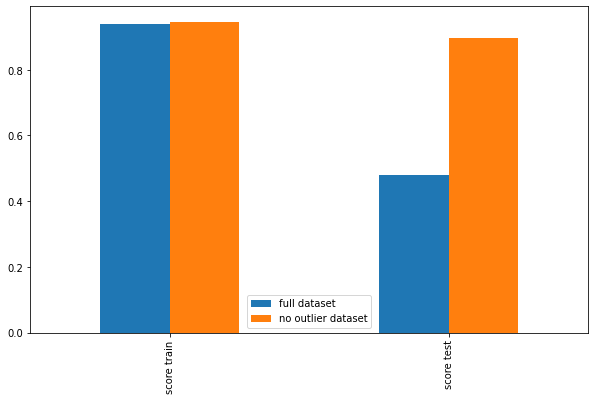

In [ ]:
plt.rcParams["figure.figsize"] = [10, 6]
pd.DataFrame(base_model).plot.bar()

Я получила очень интересные результаты, которые еще раз показывают, насколько важно сохранять максимальное количество признаков.

Когда я исключила три столбца с большим количеством пропущенных значений из набора данных, то на тестовой выборке коэффициент детерминации был на несколько миллиардов меньше нуля - очевидно, что все связи между даннми были нарушены. То же самое и касалось, когда я удалила всего два значения, которые я восприняла как выбросы, из столбца LotFrontage.

Как только я отменила удаление столбцов и этих двух значений, коэффициент детерминации модели на тестовой выборке подскочил до 0.9 - почти в два раза выше, чем коэффициент детерминации модели, где не была проведена работа с выбросами.

Вся эта работа была проведена, чтобы понять, какой набор данных брать - полный или очищенный. В итоге, я решила взять полный датасет, чтобы продемонстрировать как ансамблирование способно улучшить качество моделей на одинаковом наборе данных.

## Bagging, деревья решений

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
models = {}
# Перенесём данные по базовой модели без выбросов в словарь для сравнения моделей
models['base model full'] = base_model['full dataset']
models['base model no outlier'] = base_model['no outlier dataset']

In [ ]:
bag_lr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42).fit(X_train_full, y_train_full)

bag_lr_train_score = bag_lr.score(X_train_full, y_train_full)
bag_lr_test_score = bag_lr.score(X_test_full, y_test_full)

models['bagging decision tree'] = {'score train':bag_lr_train_score, 'score test':bag_lr_test_score}

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_reg = RandomForestRegressor(max_depth=10, random_state=42).fit(X_train_full, y_train_full)

rf_reg_train_score = rf_reg.score(X_train_full, y_train_full)
rf_reg_test_score = rf_reg.score(X_test_full, y_test_full)

models['Random forest'] = {'score train':rf_reg_train_score, 'score test':rf_reg_test_score}

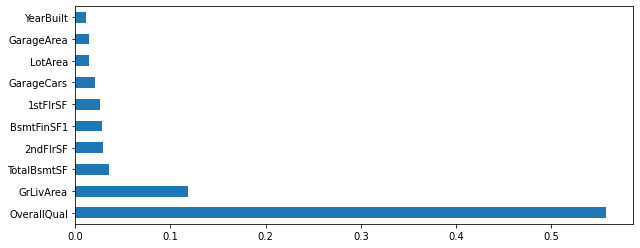

In [ ]:
plt.rcParams["figure.figsize"] = [10, 4]
# Выявляем наиболее важные признаки и выводим на график. Большое значение имеет признак Overall Qual, остальные почти равны нулю
# Собираем значения feature importance в pandas Series
feat_imp = pd.Series(rf_reg.feature_importances_)

# Собираем шапку столбцов в индекс переменной со значениями
feat_imp.index = pd.Series(X_train_full.columns)

# Сортируем по важности
feat_imp.sort_values(inplace=True, ascending=False)

# Топ 10 важности признаков
top_10_feat_imp = feat_imp.head(10)

# Визуализируем
top_10_feat_imp.plot(kind='barh')

## Stacking

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV

In [ ]:
# Создаем stacking и обучаем его на наших данных 
# estimators: Base estimators which will be stacked together. 
# Each element of the list is defined as a tuple of string (i.e. name) and an estimator instance.
# final_estimator: A regressor which will be used to combine the base estimators.
estimators = [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ]

stack_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV()).fit(X_train_full, y_train_full)

stack_reg_train_score = stack_regressor.score(X_train_full, y_train_full)
stack_reg_test_score = stack_regressor.score(X_test_full, y_test_full)

models['Stacking: LR, KNN, DTree'] = {'score train':stack_reg_train_score, 'score test':stack_reg_test_score}

# Выводы

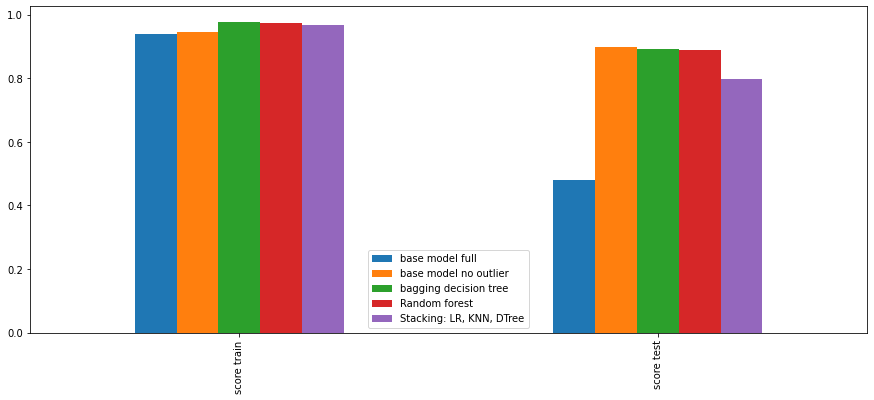

In [ ]:
plt.rcParams["figure.figsize"] = [15, 6]
pd.DataFrame(models).plot.bar()

Несмотря на то, что базовая модель без выбросов показала наилучшие результаты среди всех моделей, я не рекомендую её использование.

Базовая модель без выбросов не работала на очень многих фиксаторах генератора случайных чисел, показывая миллиардные отрицательные значения на тестовой выборке. Я полагаю, что это означает, что выбросы были убраны некорректно, потому что на полных данных и базовая модель, и все ансамбли работали без нареканий.

Из всех представленных моделей, учитывая задачу, я бы выбрала Random Forest или Bagging с использованием ансамбля деревьев решений.